# The pinhole camera model: perspective transformation

## The pinhole camera 

The pinhole camera (camera obscura) is a precursor of the modern photographic camera ([https://en.wikipedia.org/wiki/Camera_obscura](https://en.wikipedia.org/wiki/Camera_obscura)). Figure 1 illustrates a pinhole-camera device. 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Pinhole-camera.svg/640px-Pinhole-camera.svg.png)

**Figure 1**: The pinhole camera. The device consists of a dark box with a small hole through which the light can enter the box and create an image on the opposite face of the box ([https://en.wikipedia.org/wiki/Camera_obscura](https://en.wikipedia.org/wiki/Camera_obscura)) 

## Geometry
The geometry of the perspective camera is shown in Figure 2. These notes, we follow the mathematical notation from Prince's book ([Computer Vision Models](https://udlbook.github.io/cvbook/), Chapter 14). See chapter for more details.


![The geometry of the perspective projection](ProjectiveCamera.jpg)
**Figure 2**: The geometry of the perspective projection transformation (the pinhole camera). The light rays reflected on the object's surface reach the camera center (i.e., center of projection). These rays intersect the image plane forming a projection of the object. A point ${\bf w} = (u,v,w)^\mathsf{T}$ on the object to an image point ${\bf x} = (x,y)^\mathsf{T}$ on the image plane of the pinhole camera.

The mathematical model differs visually from the physics setup of the physical pinhole camera. The main difference is that the image plane is placed in front of the optical center at the same focal distance along the $w$ axis. This change simplify the mathematical notation, and flips the image upright. But, the perspective mapping remains unchanged.

## Explicit function form

The pinhole camera model maps 3-D points on an object to 2-D points on the image plane (Figure 2). A point ${\bf w} = (u,v,w)^\mathsf{T}$ on the object to an image point ${\bf x} = (x,y)^\mathsf{T}$ on the image plane of the pinhole camera according to the following model (explicit function form):

$$
\begin{align}
    x &= \frac{\phi_x\left(\omega_{11}u + \omega_{12}v + \omega_{13}w + \tau_x \right) + \gamma\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y\right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_x,\notag\\
    y &= \frac{\phi_y\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y \right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_y.
       % \label{pinhole_explicit}
\end{align}
$$

which can be written as a function:

$$
\begin{align}
{\bf x} = \text{pinhole}\left[{\bf w}, \Lambda,\Omega,\boldsymbol{\tau}\right],
\tag{2}
\end{align}
$$

where $\Lambda$ is the set of intrinsic parameters, $\Omega$ is the camera rotation, and $\boldsymbol{\tau}$ is the 3-D location of the camera center (i.e., translation). For each world point ${\bf w}\in \mathbb{R}^3$, the pinhole-camera model generates an image point ${\bf x}\in \mathbb{R}^2$. 


## The pinhole camera in matrix form

Often, we want to use matrices to represent transformations as they simplify notation, derivations, and enable efficient computation. In computer vision, the intrinsic matrix $\Lambda$ and the extrinsic matrix $[\Omega \mid \boldsymbol{\tau}]$ are used to model the camera's internal parameters and its pose in space, respectively. By combining these matrices, we can express the perspective projection in a compact matrix form, which is especially useful for projecting multiple points simultaneously.

However, matrices only represent linear transformations and the pinhole-camera model in Equation 1 is a non-linear function. This nonlinearity means that the function cannot be expressed as a single matrix in Cartesian coordinates, which are coordinates of points in Euclidean space. 

Progress can be made by converting the points (and also transformations) from Euclidean space to Projective space (https://en.wikipedia.org/wiki/Homogeneous_coordinates). In projective space, the location of points is given by homogeneous coordinates (or projective coordinates). This conversion has the advantage that all transformations in projective space are linear and, as a result, can be expressed by transformation matrices.  

When expressed in homogeneous coordinates, the explicit form of the pinhole-camera model in Equation 1 can be written in matrix form as:

$$
\begin{align}    
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    =  
    \underbrace{\begin{bmatrix}
        {\phi_x} & {\gamma} & {\delta_x} & 0 \\
         0     & {\phi_y} & {\delta_y} & 0 \\
         0     & 0      & 1        & 0 
    \end{bmatrix}}_{\text{intrinsic matrix}}
    \underbrace{\begin{bmatrix}
        {\omega_{11}} & {\omega_{12}} & {\omega_{13}} & {\tau_x} \\
        {\omega_{21}} & {\omega_{22}} & {\omega_{23}} & {\tau_y} \\
        {\omega_{31}} & {\omega_{32}} & {\omega_{33}} & {\tau_z} \\
         0          & 0           & 0           & 1 
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        u \\
        v \\
        w \\
        1
    \end{bmatrix}, 
    \tag{3}
\end{align}
$$
or in short (block matrix notation):
$$
\begin{align}
    \lambda \tilde{{\bf x}} = 
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{{\bf w}}. 
        \tag{4}
\end{align}
$$

Next, we look into two examples of using the pinhole model to create the image of 3-D points. The first example projects a single point while the second example projects a set of points describing a simple cube model.

## Numerical examples

### Example 1: Single point with synthetic camera

In this example, our goal to project a vertex of a 3-D virtual object onto the image of the scene.

In [1]:
# Libraries
import os
import imageio
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### The 3-D point
The 3-D vertex is located at ${\bf w} = \left(10,-10,20\right)^\mathsf{T}$, and its color is blue, i.e., **rgb**(0,0,255).

In [2]:
# Coordinates of the 3-D vertex
w = np.array([[10], [-10], [20]])   # Column vector
print("w =")
print(w)

# Vertex color
c = np.array([0,0,255])   # RGB color components (blue color)

w =
[[ 10]
 [-10]
 [ 20]]


#### Camera model (intrinsic and extrinsic parameters)
Assume that an image of a real scene is captured by a static camera that has the following parameters:

- **Focal lengths**: $\phi_x = 200$ and $\phi_y = 205$,
- **Principal point**: $\delta_x = 401$ and $\delta_y=305$,
- **Skew**: 0
- **Rotation**: 0 degrees,
- **Translation**: $\boldsymbol{\tau}=\left(10,0,0\right)^\mathsf{T}$,
- **Image size (width,height)**:  $800\times600$ pixels.



In [3]:
# Intrinsic parameters
phi_x   = 200.0
phi_y   = 205.0
skew    =   0.0
delta_x = 401.0
delta_y = 305.0

Lambda = np.array([[phi_x,  skew, delta_x],
                   [    0, phi_y, delta_y],
                   [    0,     0,       1]], dtype=np.float64)

print(f"Lambda = \n{Lambda}\n")

# Extrinsic parameters
# Rotation matrix
Omega = np.eye(3,3)

# Translation vector
tau   = np.array([[10.0], [0.0], [0.0]])

print(f"\nOmega = \n{Omega}\n")
print(f"tau = \n{tau}\n")

# Image size (resolution)
im_width  = 800.0
im_height = 600.0



Lambda = 
[[200.   0. 401.]
 [  0. 205. 305.]
 [  0.   0.   1.]]


Omega = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

tau = 
[[10.]
 [ 0.]
 [ 0.]]



Here, we need to perform two basic steps: 

1. Calculate the image coordinates $(x,y)$ of the vertex using the pinhole camera model, and 

2. Set the color of the pixel at $(x,y)$ to the desired color, i.e., **rgb**(0,0,255).

##### Step 1: Find the image coordinates of the vertex as seen by the camera:
Calculations:
$$
\begin{align}
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    &=  
    \underbrace{\begin{bmatrix}
        200    &   0 & 401 \\
         0     & 205 & 305 \\
         0     & 0   & 1    
    \end{bmatrix}}_{\text{intrisic matrix}}
    \underbrace{\begin{bmatrix}
        1 & 0 & 0 & 10 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        10 \\
        -10 \\
        20 \\
        1
    \end{bmatrix} \notag\\
    &=
        \begin{bmatrix}
        12020 \\
        4050 \\
        20
    \end{bmatrix} \implies
    \begin{cases}
    	x &= \frac{\lambda x}{\lambda} = \frac{12020}{20} = 601 \\
			y &= \frac{\lambda y}{\lambda} = \frac{4050}{20} = 202.5
    \end{cases}
\end{align}
$$

Code:

In [4]:
# Convert vertex coords to homogeneous coordinates
w_tilde = np.block([[w],[1]])
print(f"w_tilde = \n{w_tilde}")

# Calculate perspective projection of vertex onto image
x_tilde = Lambda @ np.block([Omega, tau]) @ w_tilde

print(f"\nx_tilde = \n{x_tilde}")

# Convert coordinates from homogeneous to Cartesian
x = x_tilde[0] / x_tilde[2]
y = x_tilde[1] / x_tilde[2]

print(f"\nx = {x[0]}, y = {y[0]}")


w_tilde = 
[[ 10]
 [-10]
 [ 20]
 [  1]]

x_tilde = 
[[12020.]
 [ 4050.]
 [   20.]]

x = 601.0, y = 202.5


##### Step 2: Set the color of the image pixel to the desired color:

   $$
   I(202, 601) \leftarrow rgb(0,0,255).
   $$

Here, $I$ is the image matrix. Its dimension is $600\times 800$ (i.e., rows $\times$ columns), and the matrix is indexed using $(i,j)$ indices. Note $(i,j)$ indices and $(x,y)$ coordinates are not equal. Instead, x-values vary with the columns of the matrix (i.e., index $j$) while y-values vary with the rows of the matrix (i.e., index $i$).  

When projecting several vertices of a 3-D object, the above two steps are repeated for all points.

### Example 2:  Projecting multiple points

#### Using a single matrix to represent the whole object

When projecting multiple points, we can stack all points as columns of a matrix and then apply the multiplication transformation directly on the matrix. For instance, the following matrix stores the 3-D coordinates of the vertices of a cube.  

$$
\begin{align}
C =
\begin{bmatrix}
   {\bf w}_1 & \dots & {\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\ 0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\ 200 & 200 & 200 & 200 & 250 & 250 & 250 & 250
  % \label{eq_Cube1}
\end{bmatrix}.
\end{align}
$$

Each column of matrix $C$ is a vertex ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$ of a cube, for $i=1,\dots,8$.  The cube is located in front of the camera as the example shown in Figure 1. The projection operation is then given by:

$$
\begin{align}
    \lambda \tilde{{\bf x}} =
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{C},  
\end{align}
$$

where $\tilde{C}$ is the cube points given in homogeneous coordinates, i.e.:

$$
\begin{align}
\tilde{C} =
\begin{bmatrix}
   \tilde{\bf w}_1 & \dots & \tilde{\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\
   0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\
   200 & 200 & 200 & 200 & 250 & 250 & 250 & 250 \\
   1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}.
\end{align}
$$



#### Helper functions

In [5]:
class Utils:
    @staticmethod
    def project_points(W: np.ndarray, 
                       Lambda: np.ndarray, 
                       Rt: np.ndarray) -> np.ndarray:
        """ Helper function to project 3D points to 2D image plane"""
        
        # Convert points to homogeneous coordinates
        W_tilde = np.vstack((W, np.ones((1, W.shape[1]))))

        print(f"W_tilde = \n{W_tilde}\n")

        # Calculate perspective projection in homogeneous coordinates
        X_tilde = Lambda @ Rt @ W_tilde
        
        print(f"X_tilde =  \n{X_tilde}\n")

        # Apply perspective division to convert coordinates from homogeneous to Cartesian
        X_tilde /= X_tilde[2,:]
        # Convert coordinates from homogeneous to Cartesian
        X = X_tilde[0:2,:]
         
        return X

    @staticmethod   
    def draw_coordinate_frame(image_points, img):    
        x0, y0 = image_points[:,0].astype(int)
        cv2.circle(img, (x0, y0), 9, (0, 0, 0), -1)

        x1, y1 = image_points[:,1].astype(int)
        img = cv2.arrowedLine(img, (x0, y0), (x1, y1), (255, 0, 0), 5)  

        x2, y2 = image_points[:,2].astype(int)
        img = cv2.arrowedLine(img, (x0, y0), (x2, y2), (0, 255, 0), 5)  

        x3, y3 = image_points[:,3].astype(int)
        img = cv2.arrowedLine(img, (x0, y0), (x3, y3), (0, 0, 255), 5)  


        # Display the image
        plt.imshow(img)
        plt.show()

    @staticmethod
    def build_Lambda(phi_x, phi_y, skew, delta_x, delta_y):
        """ Build the intrinsic camera matrix Lambda """
        Lambda = np.array([[phi_x,  skew, delta_x],
                           [    0, phi_y, delta_y],
                           [    0,     0,       1]])
        return Lambda

    @staticmethod
    def json_read(filename):
        # Parses the json file
        try:
            with open(os.path.abspath(filename)) as f:
                data = json.load(f)
            return data
        except:
            raise ValueError("Unable to read JSON {}".format(filename))
    
    

### Create a coordinate frame (u,v,w) to plot on the image
This is a simple coordinate system represented by an origin point and three points, one for each axis. We create a canonical one first and then scale its coordinates to make it visible when projected onto the image. We also need to translate the frame away from the origin of the world (i.e., away from the camera).

In [6]:
# Coordinate system (centered at the world origin)
scale_factor = 10
W   = scale_factor * np.array([
    [ 0, 1,  0,  0],
    [ 0, 0,  1,  0],
    [ 0, 0,  0,  1]
    ], dtype=np.float64)

# Translate the cube away from the camera along the positive Z-axis
W = W + np.array([[0],[0],[20]], dtype=np.float64)

We will overlay a coordinate system on an real image. This is just an example of projection using an image. The camera is synthetic, and is not the correct camera for this image. 

In [7]:
# Read and display an image (this is just an example image)
img = cv2.imread('stone.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
nRows, nCols, _ = img.shape

In [8]:
# Intrinsic parameters
phi_x   = 300.0
phi_y   = 300.0
skew    =   0.0
delta_x = nCols/2.0
delta_y = nRows/2.0


# Intrinsic camera matrix
Lambda = Utils.build_Lambda(phi_x, phi_y, skew, delta_x, delta_y)

print(f"Lambda = \n{Lambda}\n")

# Extrinsic parameters
Omega = np.eye(3,3, dtype=np.float64)
tau   = np.array([[0], [0], [10]], dtype=np.float64)

# Camera pose, i.e., the matrix [R t] of extrinsic parameters
Rt = np.block([Omega, tau])

# Print camera extrinsic parameters
print(f"Rt = \n{Rt}\n")


Lambda = 
[[300.    0.  567.5]
 [  0.  300.  553. ]
 [  0.    0.    1. ]]

Rt = 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. 10.]]



In [9]:
image_points = Utils.project_points(W, Lambda, Rt)
print(f"\nProjected image points:\n{image_points}")

W_tilde = 
[[ 0. 10.  0.  0.]
 [ 0.  0. 10.  0.]
 [20. 20. 20. 30.]
 [ 1.  1.  1.  1.]]

X_tilde =  
[[17025. 20025. 17025. 22700.]
 [16590. 16590. 19590. 22120.]
 [   30.    30.    30.    40.]]


Projected image points:
[[567.5 667.5 567.5 567.5]
 [553.  553.  653.  553. ]]


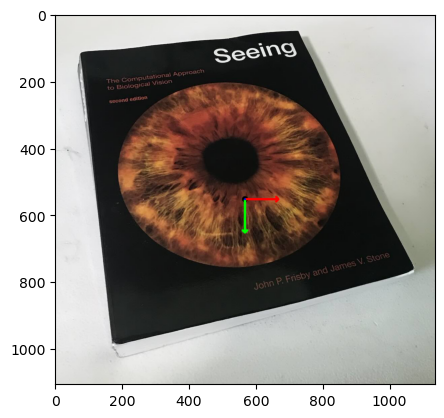

In [10]:
# Draw the 3D coordinate frame
Utils.draw_coordinate_frame(image_points, img)

### Example 3:  Projecting multiple points using opencv's perspective-projection function

The `cv2.projectPoints()` function in OpenCV requires the rotation as a rotation vector (`rvec`), not a rotation matrix. If a rotation matrix is available, it must be converted to a rotation vector before being passed to `cv2.projectPoints()`.

**Conversion from Rotation Matrix to Rotation Vector:**

The `cv2.Rodrigues()` function can be used to convert a `3x3` rotation matrix into a `3x1` rotation vector (axis-angle representation) and vice-versa.

In [11]:
# Convert the rotation matrix R and translation vector t to a rotation vector rvec 
# and translation vector tvec
rvec = cv2.Rodrigues(Omega)[0]
tvec = tau.reshape(3,)  # tvec must be a 1-D array of shape (3,)

# Distortion Coefficients (all zeros for "zero warping")
distCoeffs = np.zeros((5, 1), dtype=np.float32) # or (4,1) or (8,1) based on your calibration

print(f"W = \n{W}\n")

# Project the axis points onto the image plane
image_axes, jac = cv2.projectPoints(W, rvec, tvec, Lambda, distCoeffs)

# Opencv changes the format of the points. 
# Remove extra brackets from the output of cv2.projectPoints
image_axes = image_axes.squeeze().T

print(f"Projected image points = \n{image_axes}\n")


W = 
[[ 0. 10.  0.  0.]
 [ 0.  0. 10.  0.]
 [20. 20. 20. 30.]]

Projected image points = 
[[567.5 667.5 567.5 567.5]
 [553.  553.  653.  553. ]]



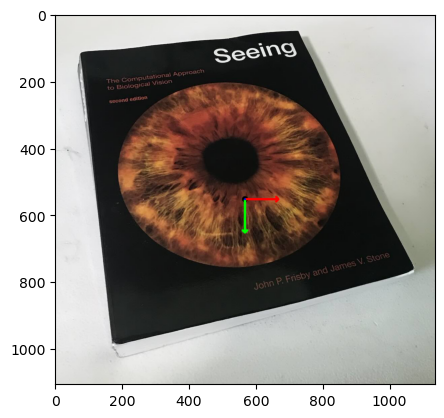

In [12]:
# Draw the 3D coordinate frame
Utils.draw_coordinate_frame(image_axes, img)

### Example 4:  Projecting points using an actual calibration file

In this example, we will render a virtual object in the first frame of each video in the soldiers-tracking dataset (https://www.epfl.ch/labs/cvlab/data/soldiers-tracking/). The dataset has six videos of an indoor scene captured from synchronized cameras from multiple view points. The dataset contains the videos and the camera-calibration data for all cameras.

The squared calibration pattern that appears in the image was the reference pattern used for calibrating the cameras. As a result, the planes of the calibration pattern define the world coordinate system.  You will project the same coordinate frame that we did for the previous examples. 

The calibration data (i.e., intrinsic and extrinsic parameters) for each camera is the json file `calibration.json`, which is a text file that can be opened by standard text editors. You can also read the content of the json file into your program by calling a library function in Python. The dataset comes with the Python script `example.py` that reads the json file and project test points onto the images.

You will need to extract the calibration data from the json file. For each camera, extract the matrix of intrinsic parameters $K$, the camera rotation matrix $R$, and the translation vector $t$. These matrices, in the notation used in these notes,  correspond to the matrices $\Lambda$, $\Omega$, and $\boldsymbol{\tau}$, respectively.

#### Split video into a sequence of images

In [13]:
# Extract frames from video
import os
if not os.path.exists('frames') or len(os.listdir('frames')) == 0:
    os.makedirs('frames', exist_ok=True)
    !ffmpeg -i 3_2.mp4 -vsync 0 -q:v 2 frames/%05d.jpg

#### Read one image frame

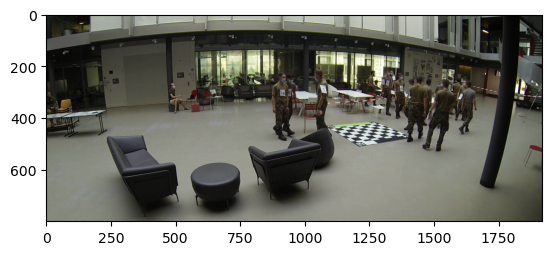

In [14]:
# Read and display an image frame
img = cv2.imread('frames/00040.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
nRows, nCols, _ = img.shape

# Display the image
plt.imshow(img)
plt.show()

#### Load the calibration data for the camera that acquired the image
Read the camera-calibration data from the `calibration.json`. The calibration file contains intrinsic and extrinsic parameters for multiple camera views. We select the one corresponding to the camera that captured the video. 

In [15]:
# Read calibration data from file
calibration = Utils.json_read("calibration.json")

# Calibration file has multiple views
views = calibration.keys()
print(f"Available views: {views}")

# Select a view
view = list(views)[2]

# Print selected view
print(f"Selected view: {view}")

Available views: dict_keys(['6_5', '6_4', '3_2', '6_3', '3_4', '6_1'])
Selected view: 3_2


In [16]:
# Get the calibration matrices
Lambda = np.array(calibration[view]['K'])      # Intrinsic params.
Omega  = np.array(calibration[view]['R'])      # Rotation
tau    = np.array(calibration[view]['t'])      # Translation
dist   = np.array(calibration[view]['dist'])   # Lens distortion


print("----------------------------------------")
print("Calibration matrices")
print("----------------------------------------")
print("Lambda = \n",np.matrix(Lambda),"\n")
print("Omega = \n",np.matrix(Omega),"\n")
print("tau = \n",np.matrix(tau),"\n")
print("lens distortion = \n",np.matrix(dist),"\n")



----------------------------------------
Calibration matrices
----------------------------------------
Lambda = 
 [[868.08784042   0.         976.81457233]
 [  0.         864.65174318 387.22218521]
 [  0.           0.           1.        ]] 

Omega = 
 [[ 0.32289979  0.94638426  0.00962108]
 [ 0.21259462 -0.06262249 -0.97513176]
 [-0.92224685  0.31691523 -0.22141699]] 

tau = 
 [[2.00080565 0.2555784  7.81651077]] 

lens distortion = 
 [[-0.32747543  0.1405339   0.00073461  0.00107595 -0.02708125]] 



#### Remove lens distortion from image

Removing lens distortion from an image is an important step in camera calibration and computer vision. Real camera lenses introduce distortions that cause straight lines to appear curved in images. To obtain accurate measurements and projections, we need to correct these distortions.

The OpenCV function `cv2.undistort()` uses the intrinsic parameters and the lens-distortion estimated model to produce a corrected image.

This process ensures that subsequent geometric computations and projections are performed on an image that accurately represents the scene geometry.



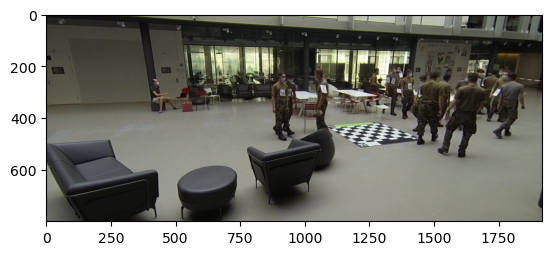

In [17]:
# Image corrected for (spherical) lens distortion
img_corrected = cv2.undistort(img, Lambda, dist)
plt.figure()
plt.imshow(img_corrected)

#### This time we will not translate the coordinate frame
In the previous examples, we positioned the virtual coordinate frame object away from the camera along the w-axis. Another important difference to notice in this example is that the cameras will not be centered at the origin of the world coordinate system as it was the case in the previous examples. 

The camera being away from the origin having its coordinate system not aligned with the world plays a role when we want to display the camera. If we want to display the camera located in the scene, we need to use the inverse of the extrinsics matrix. This is not done in these notes.

In [18]:
# Coordinate system (centered at the world origin)
scale_factor = 2 
W   = scale_factor * np.array([
    [ 0, 1,  0,  0],
    [ 0, 0,  1,  0],
    [ 0, 0,  0,  1]
    ], dtype=np.float64)

# Translate the cube away from the camera along the positive Z-axis
# W = W + np.array([[0],[0],[20]], dtype=np.float64)

#### Convert the camera pose (extrinsic parameters) to use with `cv2.projectPoints()` 

In [20]:
# Convert the rotation matrix R and translation vector t to a rotation vector rvec 
# and translation vector tvec
rvec = cv2.Rodrigues(Omega_cam)[0]
tvec = tau_cam.reshape(3,)  # tvec must be a 1-D array of shape (3,)

# Distortion Coefficients (all zeros for "zero warping")
distCoeffs = dist # or (4,1) or (8,1) based on your calibration

print(f"W = \n{W}\n")

# Project the axis points onto the image plane
image_axes, jac = cv2.projectPoints(W, rvec, tvec, Lambda, distCoeffs)

# Opencv changes the format of the points. 
# Remove extra brackets from the output of cv2.projectPoints
image_axes = image_axes.squeeze().T

print(f"Projected image points = \n{image_axes}\n")



W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[1194.50686833 1338.04503854 1351.99466719 1205.38445347]
 [ 414.95402272  479.85406348  399.85962642  196.40736318]]



#### Display the world coordinate frame
The world coordinate system is centered in the middle of the edge of the checkerboard pattern, centered at the green band. The w-axis points up. This is the same coordinate system used in OpenCV. 

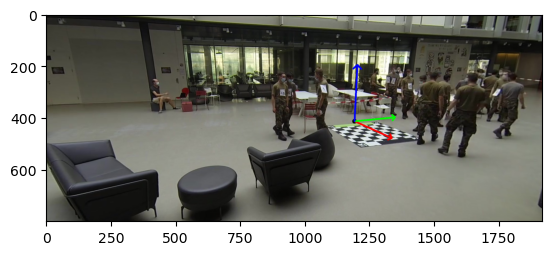

In [22]:
# Draw the 3D coordinate frame
Utils.draw_coordinate_frame(image_axes, img_corrected)